# Model Comparison - Descriminator Trainer

This notebook trains a network to mimic the Blackbox version, using all clients in the training set to perform the task. We use the test set to evaluate how close the Descriminator model is from the Blackbox version.

## Imports

In [1]:
import numpy as np

import tensorflow as tf
from keras.models import Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import keras.backend as K
from keras.datasets import mnist
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import os.path
import pickle
import math
import random
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.set_random_seed(0)

## Parameters

In [3]:
# model params
num_classes = 10
max_epochs = 25
save_every = 1
descriminator_epochs = 25

# client params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets
    
minibatch_size = None                           # number of samples to operate on at one time
                                                # - can vary to optimize computing requirements
                                                # - if None, will evaluate the client's whole batch regardless of its size
    
batches_per_train_step = 20                     # after averaging the gradients from X clients, we will apply them to the model

shuffle_clients = True

# dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

# input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model

## Load Data

In [4]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [5]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [6]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


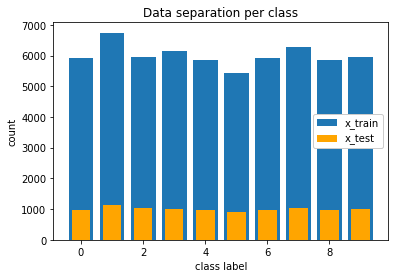

In [7]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='tab:blue')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='orange', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

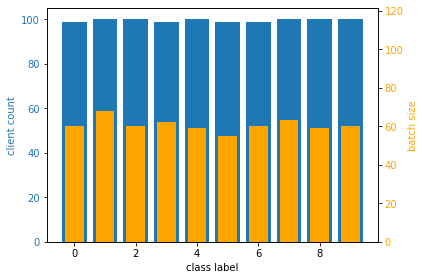

Clients per class:  99.6 ~= 100
Total number of clients: 996
Average batch size: 60.6


In [8]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

client_counts = {}
batch_sizes = {}
x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples_per_class = len(x_train_seperated[class_idx])
    samples_per_client = n_samples_per_class / clients_per_class
    better_batch_size = int(math.ceil(samples_per_client))

    count = 0
    for i in range(ceil(n_samples_per_class, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        count += 1
    client_counts[class_idx] = count
    batch_sizes[class_idx] = better_batch_size
        
# double check that the clients_per_class is upheld per class
# (blue bars should be uniform, orange should change according to class):
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('class label')
ax1.set_ylabel('client count', color=color)
plt.bar(client_counts.keys(), [v for v in client_counts.values()], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.set_ylabel('batch size', color=color)  # we already handled the x-label with ax1
plt.bar(batch_sizes.keys(), [v for v in batch_sizes.values()], color=color, width=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.mean([v for v in batch_sizes.values()])*2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Clients per class:  {} ~= {}'.format(np.mean([v for v in client_counts.values()]), clients_per_class))
print('Total number of clients: {}'.format(np.sum([v for v in client_counts.values()])))
print('Average batch size: {}'.format(np.mean([v for v in batch_sizes.values()])))

## Build Model

In [9]:
def blackbox_model(input_layer, training=True):
    h = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(input_layer)
    h = Conv2D(64, (3, 3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2, 2))(h)
    h = Dropout(0.25)(h, training=training)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    h = Dropout(0.5)(h, training=training)
    output_layer = Dense(num_classes, activation='softmax')(h)
    
    return output_layer

In [10]:
# to remove model complexity, the blackbox and descriminator models will be kept the same

def descriminator_model(input_shape, training=True):
    model = blackbox_model(input_shape, training)
    
    return model

In [11]:
input_shape = (target_rows, target_cols, 1)

## Graph Creation

In [12]:
# add nodes for input and blackbox pred label
x = Input(shape=input_shape)
y_blackbox = blackbox_model(x, training=False)    # NOT training this model

# add node for descriminator pred label
y_descriminator = descriminator_model(x, training=True)

# we don't care about the 'true' label
# y_true = Input(shape=(num_classes, ))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [13]:
# define loss function in terms of y_pred and y_true
loss = tf.keras.losses.MSE(y_blackbox, y_descriminator)

# Setup metrics to look at during training:
_, acc_op = tf.metrics.accuracy(labels=tf.argmax(y_blackbox, 1),
                                predictions=tf.argmax(y_descriminator,1))

## Optimizer definition - nothing different from any classical example
optimizer = tf.train.AdamOptimizer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [14]:
# INSPIRED by https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients

# Fetch a list of our network's trainable parameters.
trainable_vars = tf.trainable_variables()

# Create variables to store accumulated gradients
accumulators = [
    tf.Variable(
        tf.zeros_like(tv.initialized_value()),
        trainable=False
    ) for tv in trainable_vars
]

# Create a variable for counting the number of accumulations
accumulation_counter = tf.Variable(0.0, trainable=False)

# Compute gradients; grad_pairs contains (gradient, variable) pairs
grad_pairs = optimizer.compute_gradients(loss, trainable_vars)

# Create operations which add a variable's gradient to its accumulator.
accumulate_ops = [
    accumulator.assign_add(
        grad
    ) for (accumulator, (grad, var)) in zip(accumulators, grad_pairs)
]

# The final accumulation operation is to increment the counter
accumulate_ops.append(accumulation_counter.assign_add(1.0))

# Update trainable variables by applying the accumulated gradients
# divided by the counter. Note: apply_gradients takes in a list of 
# (grad, var) pairs
train_step = optimizer.apply_gradients(
    [(accumulator / accumulation_counter, var) \
        for (accumulator, (grad, var)) in zip(accumulators, grad_pairs)]
)

# Accumulators must be zeroed once the accumulated gradient is applied.
zero_ops = [
    accumulator.assign(
        tf.zeros_like(tv)
    ) for (accumulator, tv) in zip(accumulators, trainable_vars)
]

# Add one last op for zeroing the counter
zero_ops.append(accumulation_counter.assign(0.0))

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


## Split Training

In [15]:
# Initialize the session

sess = tf.Session()
sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [16]:
# Train

print('Training the model...\n')

# Loop through every trained blackbox model, and train a new descriminator on it:
for blackbox_epoch in range(max_epochs):
    if (blackbox_epoch+1) % save_every == 0 or blackbox_epoch+1 == max_epochs:
        print('='*40)
        print('Training on blackbox_e{}'.format(blackbox_epoch+1))
        
        for epoch in range(descriminator_epochs):
            print('.'*10)
            print('Epoch %s:' % str(epoch+1))

            batch_idxs = list(range(len(x_batches)))
            if shuffle_clients:
                # shuffle the batches each time
                random.shuffle(batch_idxs)

            # Run the zero_ops to initialize the accumulators
            sess.run(zero_ops)

            # Fancy progress bar
            samples = x_train.shape[0]
            pbar = tqdm_notebook(total=samples)

            # Keep track of average loss/acc per class:
            accs_train = []
            losses_train = []

            # Iterate over clients:
            grad_feed_dict = dict()
            for i, batch_idx in enumerate(batch_idxs):
                class_idx, x_batch = x_batches[batch_idx]
                _, y_batch = y_batches[batch_idx]

                # Iterate over the client's batch in minibatches:
                j = 0
                while(j < len(x_batch)):
                    if minibatch_size is None:
                        # use whole batch (no minibatch)
                        x_minibatch = x_batch
                        y_minibatch = y_batch
                    else:
                        x_minibatch = x_batch[j:(j+minibatch_size)]
                        y_minibatch = y_batch[j:(j+minibatch_size)]

                    # get the gradients and determine accuracy/loss of model on training dataset
                    _, acc_train, loss_train = sess.run([accumulate_ops, acc_op, loss], feed_dict={x: x_minibatch})

                    # add acc and loss metrics for batch:
                    accs_train.append(acc_train)
                    losses_train.append(np.mean(loss_train))

                    if minibatch_size is None:
                        break
                    else:
                        j += minibatch_size

                # increment pbar
                pbar.update(len(x_batch))
                pbar.set_description('train_acc={:.3f} | train_loss={:.3f}'.format(np.mean(accs_train), np.mean(losses_train)))

                # perform a train step every batches_per_train_step number of batches:
                if (i > 0 and i % batches_per_train_step == 0) or i == len(batch_idxs) - 1:
                    # Run the train_step ops to update the weights based on our accumulated gradients
                    sess.run(train_step)

                    # zero out the accumulators
                    sess.run(zero_ops)

            pbar.update(x_train.shape[0] - pbar.n)
            pbar.close()

            # Calculate test acc and loss
            acc_test, loss_test = sess.run([acc_op, loss], feed_dict={x: x_test})

            # Update progress bar
            print('Train Accuracy: {:.3f} | Loss: {:.3f}'.format(np.mean(accs_train), np.mean(losses_train)))
            print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test, np.mean(loss_test)))
            print()

            if epoch+1 == descriminator_epochs:
                # checkpoint params
                checkpoint_folder = "./checkpoints/blackbox_e{}__descriminator_e{}".format(blackbox_epoch+1, epoch+1)
                os.makedirs(checkpoint_folder, exist_ok=True)
                blackbox_weights_path = os.path.join(checkpoint_folder, 'descriminator_checkpoint.ckpt')

                # Save the weights
                saver.save(sess, blackbox_weights_path)
                #model.save_weights(blackbox_weights_path)
                print('Saved the updated weights')
    else:
        pass

Training the model...

Training on blackbox_e1
..........
Epoch 1:



Train Accuracy: 0.135 | Loss: 0.000
Test Accuracy: 0.059 | Loss: 0.000

..........
Epoch 2:


KeyboardInterrupt: 